In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

import json
from anytree.importer import JsonImporter
from anytree import PreOrderIter

In [2]:
from scipy import stats
from scipy.stats import ttest_rel,ttest_ind,mannwhitneyu,normaltest,shapiro,sem

import statsmodels.api as sm
import pylab as py

In [3]:
home_dir = '/Users/dbao/My_Drive'+'/road_construction/data/2022_online/'
map_dir = 'active_map/'
# data_dir  = 'data/preprocessed'
# out_dir = home_dir + 'figures/cogsci_2022/'
out_dir2 = home_dir + 'stat_model/'
R_out_dir = home_dir + 'R_analysis_data/'

In [4]:
data_puzzle_level = pd.read_csv(R_out_dir +  'data.csv')
puzzleID_order_data = data_puzzle_level.sort_values(["subjects","puzzleID","condition"])
data_choice_level = pd.read_csv(R_out_dir +  'choice_level/choicelevel_data.csv')

data_choice_level['sqrt_leftover'] = np.sqrt(data_choice_level.leftover)
puzzleID_order_data['sqrt_nos'] = np.sqrt(puzzleID_order_data.nos)
puzzleID_order_data['log_RT1'] = np.log(puzzleID_order_data.RT1)

single_condition_data = puzzleID_order_data[puzzleID_order_data['condition']==1].copy()
single_condition_data = single_condition_data.reset_index()
sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index()

with open(home_dir +'tree_data/undo_tree', 'r') as file:
    undo_tree = json.load(file)

In [5]:
def sigmoid(x):
    e = np.exp(1)
    y = 1/(1+e**(-x))
    return y


single_condition_data['sqrt_leftover'] = np.sqrt(single_condition_data.leftover)
single_condition_data['sqrt_numFullUndo'] = np.sqrt(single_condition_data.numFullUndo)
# single_condition_data['percentile_numFullUndo'] = single_condition_data.numFullUndo.rank(method='min')

In [6]:
# helper functions
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

# add p-value to figure
def text(p):
    if p == 0:
        axs.text((x1+x2)*.5, y+h,  r"$p = {:.1f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)
    elif p < 0.001:
        axs.text((x1+x2)*.5, y+h, r"$p = {0:s}$".format(as_si(p,1)), ha='center', va='bottom', color=col, fontsize = 8)
    elif p > 0.1:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.2f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)

    elif 0.01 < p < 0.1:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.3f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)
    else:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.4f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)

## Check the position where they "first" made errors, and whether undo terminal is that


### undo terminal is not the start city

In [22]:
accu_error_3 = []

for sub in range(101):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    accu_error_puzzle = []
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        

        # last undo index when it is not the start city
        lastUndo_idx_nostart = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]!=0)].index 
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx_nostart:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1
            if dat_sbj_pzi.loc[x-j,"allMAS"] - dat_sbj_pzi.loc[x-j,"currMas"] == 0:
                lastUndo_idx_nostart = lastUndo_idx_nostart.drop(x)
        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx_nostart,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        # cumulative error at the state before undo terminal
        df_undoTarget_before = dat_sbj_pzi.loc[lastUndo_idx_nostart-1,:]
        accu_severity_error_before = list(df_undoTarget_before['allMAS'] - df_undoTarget_before['currMas'])
        
        category = [np.nan]*len(accu_severity_error) # the number of undo terminal
        
        for i in range(len(accu_severity_error)): 
            if accu_severity_error_before[i]==0: # undo too much
                category[i] = 0
            elif (accu_severity_error[i]==0)&(accu_severity_error_before[i]>0): # undo exactly the right amount
                category[i] = 1
            elif accu_severity_error[i] > 0: # undo too little
                category[i] = 2
        
        accu_error_puzzle.extend(category)

    accu_error_puzzle =  np.array(accu_error_puzzle)
    accu_error_3.append([np.sum(accu_error_puzzle==0), np.sum(accu_error_puzzle==1) ,np.sum(accu_error_puzzle==2)]) # sum of each subject
    
accu_error_3 = np.array(accu_error_3)


In [23]:
# exclude some never undoing subjects
accu_error_3_new = accu_error_3[np.where(np.sum(np.array(accu_error_3),axis=1)!=0),:]
accu_error_3_new = accu_error_3_new.squeeze()
accu_error_3_p = accu_error_3_new/ np.sum(accu_error_3_new,axis = 1)[:,None]

Text(0, 0.5, 'Proportion')

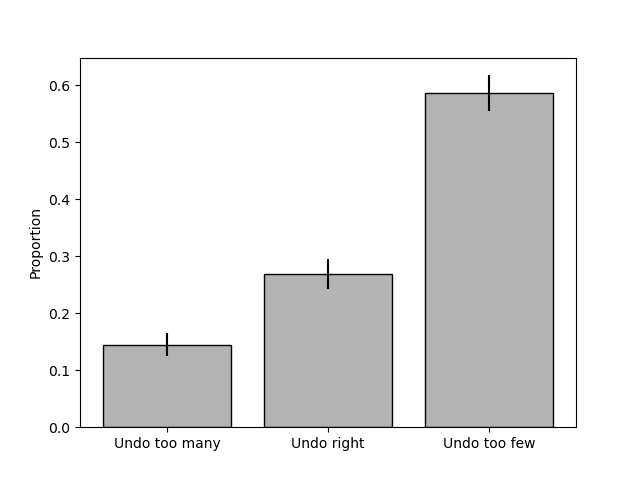

In [24]:
%matplotlib widget
plt.figure()
plt.bar(range(3), np.mean(accu_error_3_p,axis=0),
        color=[.7,.7,.7], edgecolor = 'k', 
        yerr=np.std(accu_error_3_p,axis = 0)/np.sqrt(accu_error_3_p.shape[0]))
plt.xticks([0,1,2], ['Undo too many','Undo right','Undo too few'])
plt.ylabel('Proportion')

### When undo terminal is the start city

In [25]:
accu_error_2 = []

for sub in range(101):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    accu_error_puzzle = []
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()    

        # last undo index when it is not the start city
        lastUndo_idx_start = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]==0)].index
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx_start:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1
            if dat_sbj_pzi.loc[x-j,"allMAS"] - dat_sbj_pzi.loc[x-j,"currMas"] == 0:
                lastUndo_idx_start = lastUndo_idx_start.drop(x)
        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx_start,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        # cumulative error at the state before undo terminal
        df_undoTarget_before = dat_sbj_pzi.loc[lastUndo_idx_start-1,:]
        accu_severity_error_before = list(df_undoTarget_before['allMAS'] - df_undoTarget_before['currMas'])
        
        category = [np.nan]*len(accu_severity_error)
        
        for i in range(len(accu_severity_error)): 
            if accu_severity_error_before[i]==0: # undo too much
                category[i] = 0
            elif (accu_severity_error[i]==0)&(accu_severity_error_before[i]>0): # undo exactly the right amount
                category[i] = 1
        
        accu_error_puzzle.extend(category)

        
    accu_error_puzzle =  np.array(accu_error_puzzle)
    accu_error_2.append([np.sum(accu_error_puzzle==0), np.sum(accu_error_puzzle==1)])
    
accu_error_2 = np.array(accu_error_2)

In [26]:
# exclude some never undoing subjects
accu_error_2_new = accu_error_2[np.where(np.sum(np.array(accu_error_2),axis=1)!=0),:]
accu_error_2_new = accu_error_2_new.squeeze()
accu_error_2_p = accu_error_2_new/ np.sum(accu_error_2_new,axis = 1)[:,None]

Text(0, 0.5, 'Proportion')

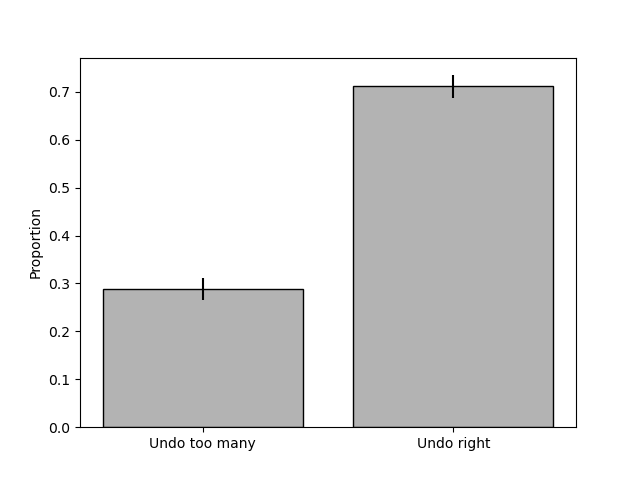

In [27]:
%matplotlib widget
plt.figure()
plt.bar(range(2), np.mean(accu_error_2_p,axis=0),
        color=[.7,.7,.7], edgecolor = 'k', 
        yerr=np.std(accu_error_2_p,axis = 0)/np.sqrt(accu_error_2_p.shape[0]))
plt.xticks([0,1], ['Undo too many','Undo right'])
plt.ylabel('Proportion')

### Total

In [46]:
accu_error_2 = accu_error_2.squeeze()
accu_error_3 = accu_error_3.squeeze()
accu_error_total = np.sum(accu_error_2,axis = 1) + np.sum(accu_error_3,axis = 1)

accu_error_2_new2 = accu_error_2[np.where(accu_error_total!=0),:].squeeze()
accu_error_3_new2 = accu_error_3[np.where(accu_error_total!=0),:].squeeze()
accu_error_total_new = accu_error_total[np.where(accu_error_total!=0)].squeeze()

accu_error_2_p2 = accu_error_2_new2/accu_error_total_new[:,None]
accu_error_3_p2 = accu_error_3_new2/accu_error_total_new[:,None]


Text(0, 0.5, 'Proportion')

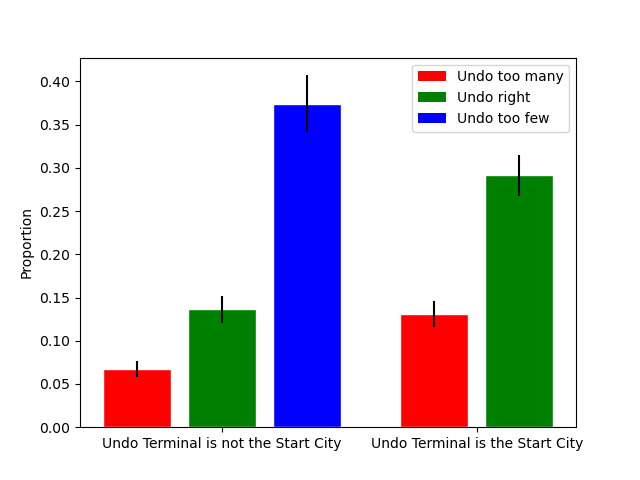

In [70]:
%matplotlib widget

plt.figure()
plt.bar(range(3), np.mean(accu_error_3_p2,axis=0),
        color= ["red", "green", "blue"], edgecolor = 'w', 
        yerr= np.std(accu_error_3_p2,axis = 0)/np.sqrt(accu_error_3_p2.shape[0]))
plt.bar([3.5,4.5], np.mean(accu_error_2_p2,axis=0),
        edgecolor = 'w', 
        color= ["red", "green"],
        yerr= np.std(accu_error_2_p2,axis = 0)/np.sqrt(accu_error_2_p2.shape[0])
               )
#plt.legend(color = ["red", "blue", "green"],
#           labels = ['Undo too many','Undo right','Undo too few'])
legend_elements = [    Patch(facecolor='red', label='Undo too many'),    Patch(facecolor='green', label='Undo right'),    Patch(facecolor='blue', label='Undo too few')]

# create the legend
plt.legend(handles=legend_elements)


plt.xticks([1,4], ['Undo Terminal is not the Start City','Undo Terminal is the Start City'])
plt.ylabel('Proportion')